<a href="https://colab.research.google.com/github/Vittori00/BB84-Protocol/blob/main/BB84_Vittori_603188.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# %% Cell 0 - Installazione pacchetti (solo se non già installati)
!pip install qiskit
!pip install qiskit-aer
!pip install matplotlib
!pip install numpy
!pip install pylatexenc

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
import matplotlib.pyplot as plt
import numpy as np
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=d832fc7e3b3f2529c0d9aec7592c260afe55fd43d5c0d93aa3eebabc2be47368
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


=== Project Outcomes: Scenario 1 - IDEAL CONDITIONS ===
L_init: 300
Sifted key length: 145
Mismatches: 0
Mismatch Ratio Rmis: 0.0


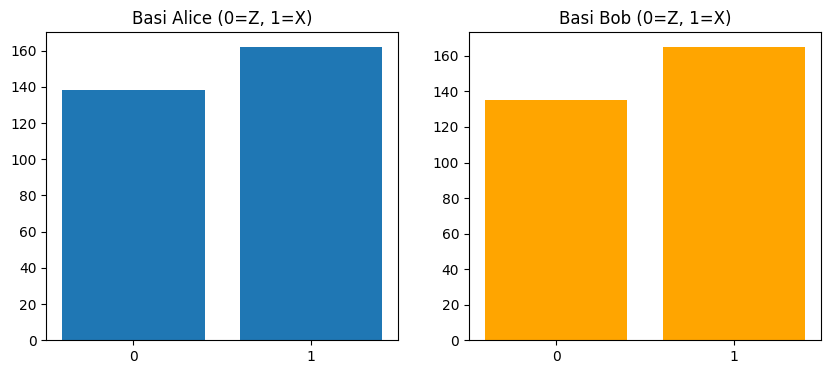

In [ ]:
# %% Cell 1 - Parametri globali
Linit = 300
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

simulator = AerSimulator()

# %% Cell 2 - Funzioni di supporto

def prepare_qubit(bit: int, basis: int) -> QuantumCircuit:
    """
    Prepara un qubit secondo il bit e la base scelta da Alice.
    basis=0 => base Z, basis=1 => base X
    """
    qc = QuantumCircuit(1, 1)
    if bit == 1:
        qc.x(0)        # stato |1>
    if basis == 1:
        qc.h(0)        # base X
    return qc

def measure_qubit(qc: QuantumCircuit, basis: int) -> QuantumCircuit:
    """
    Misura un qubit nella base scelta da Bob.
    basis=0 => misura in Z, basis=1 => misura in X
    """
    if basis == 1:
        qc.h(0)        # cambia base a X
    qc.measure(0, 0)
    return qc

# %% Cell 3 - Simulazione di BB84 (scenario ideale)
def bb84_ideal(L: int, seed: int = None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    alice_bits  = [random.randint(0,1) for _ in range(L)]
    alice_bases = [random.randint(0,1) for _ in range(L)]
    bob_bases   = [random.randint(0,1) for _ in range(L)]
    bob_results = []

    for a_bit, a_basis, b_basis in zip(alice_bits, alice_bases, bob_bases):
        qc = prepare_qubit(a_bit, a_basis)
        qc = measure_qubit(qc, b_basis)
        job = simulator.run(qc, shots=1)
        counts = job.result().get_counts()
        measured = int(list(counts.keys())[0])
        bob_results.append(measured)

    # Sifting
    sift_idx = [i for i,(ab,bb) in enumerate(zip(alice_bases,bob_bases)) if ab==bb]
    alice_sift = [alice_bits[i] for i in sift_idx]
    bob_sift   = [bob_results[i] for i in sift_idx]

    # Metriche
    sift_len = len(alice_sift)
    mismatches = sum(1 for a,b in zip(alice_sift,bob_sift) if a!=b)
    Rmis = mismatches/sift_len if sift_len>0 else None

    return {
        "alice_bits": alice_bits, "alice_bases": alice_bases,
        "bob_bases": bob_bases,   "bob_results": bob_results,
        "sift_idx": sift_idx,     "alice_sift": alice_sift,
        "bob_sift": bob_sift,     "sift_len": sift_len,
        "mismatches": mismatches, "Rmis": Rmis
    }

# %% Cell 4 - Esecuzione scenario ideale con Linit=300
res = bb84_ideal(Linit, seed=SEED)

print("=== Project Outcomes: Scenario 1 - IDEAL CONDITIONS ===")
print(f"L_init: {Linit}")
print(f"Sifted key length: {res['sift_len']}")
print(f"Mismatches: {res['mismatches']}")
print(f"Mismatch Ratio Rmis: {res['Rmis']}")

# %% Cell 5 - Grafici dei Project Outcomes

# Grafico 1: distribuzione basi di Alice e Bob
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(res["alice_bases"], bins=[-0.5,0.5,1.5], rwidth=0.8)
axs[0].set_xticks([0,1])
axs[0].set_title("Basi Alice (0=Z, 1=X)")

axs[1].hist(res["bob_bases"], bins=[-0.5,0.5,1.5], rwidth=0.8, color="orange")
axs[1].set_xticks([0,1])
axs[1].set_title("Basi Bob (0=Z, 1=X)")
plt.show()

# Grafico 2: distribuzione della lunghezza siftata (più run)
def sample_sift_lengths(L, trials=200, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    lens = []
    for _ in range(trials):
        r = bb84_ideal(L)
        lens.append(r["sift_len"])
    return lens

sift_lens = sample_sift_lengths(Linit, trials=300, seed=SEED)
plt.figure(figsize=(6,4))
plt.hist(sift_lens, bins=20, edgecolor="black", alpha=0.7)
plt.axvline(np.mean(sift_lens), color="red", linestyle="--", label=f"media={np.mean(sift_lens):.1f}")
plt.title(f"Distribuzione sifted key length (Linit={Linit}, 300 run)")
plt.xlabel("Sifted key length")
plt.ylabel("Frequenza")
plt.legend()
plt.show()


In [ ]:
# %% Cell 1 - Funzione per costruire il modello di rumore
def build_noise_model(p: float, error_type: str = "bit-flip") -> NoiseModel:
    """
    Crea un NoiseModel di Qiskit per il canale quantistico.
    error_type può essere: "bit-flip", "phase-flip", "bit-phase"
    """
    noise_model = NoiseModel()

    if error_type == "bit-flip":
        error = pauli_error([("X", p), ("I", 1 - p)])
    elif error_type == "phase-flip":
        error = pauli_error([("Z", p), ("I", 1 - p)])
    elif error_type == "bit-phase":
        error = pauli_error([("Y", p), ("I", 1 - p)])
    else:
        raise ValueError("Tipo di errore non valido.")

    # Applica l’errore a ogni operazione su un singolo qubit
    noise_model.add_all_qubit_quantum_error(error, ["id", "x", "h"])
    return noise_model

# %% Cell 2 - Simulazione BB84 con rumore di canale
def bb84_channel_errors(L: int, p: float, error_type: str = "bit-flip", seed: int = None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    alice_bits  = [random.randint(0,1) for _ in range(L)]
    alice_bases = [random.randint(0,1) for _ in range(L)]
    bob_bases   = [random.randint(0,1) for _ in range(L)]
    bob_results = []

    noise_model = build_noise_model(p, error_type)
    noisy_simulator = AerSimulator(noise_model=noise_model)

    for a_bit, a_basis, b_basis in zip(alice_bits, alice_bases, bob_bases):
        qc = prepare_qubit(a_bit, a_basis)
        qc = measure_qubit(qc, b_basis)
        job = noisy_simulator.run(qc, shots=1)
        counts = job.result().get_counts()
        measured = int(list(counts.keys())[0])
        bob_results.append(measured)

    # Sifting
    sift_idx = [i for i,(ab,bb) in enumerate(zip(alice_bases,bob_bases)) if ab==bb]
    alice_sift = [alice_bits[i] for i in sift_idx]
    bob_sift   = [bob_results[i] for i in sift_idx]

    # Metriche
    sift_len = len(alice_sift)
    mismatches = sum(1 for a,b in zip(alice_sift,bob_sift) if a!=b)
    Rmis = mismatches/sift_len if sift_len>0 else None

    return {
        "alice_bits": alice_bits, "alice_bases": alice_bases,
        "bob_bases": bob_bases,   "bob_results": bob_results,
        "sift_idx": sift_idx,     "alice_sift": alice_sift,
        "bob_sift": bob_sift,     "sift_len": sift_len,
        "mismatches": mismatches, "Rmis": Rmis,
        "p": p, "error_type": error_type
    }

# %% Cell 3 - Project Outcomes per Scenario 2 (Linit=300, vari p)
ps = np.linspace(0, 0.2, 9)  # da 0 a 0.2 in passi di 0.025
results = { "bit-flip": [], "phase-flip": [], "bit-phase": [] }

for etype in results.keys():
    for p in ps:
        r = bb84_channel_errors(Linit, p, error_type=etype, seed=SEED)
        results[etype].append(r)

# Grafico: Mismatch Ratio Rmis in funzione di p
plt.figure(figsize=(7,5))
for etype, rlist in results.items():
    plt.plot(ps, [r["Rmis"] for r in rlist], marker="o", label=etype)
plt.xlabel("Probabilità di errore p")
plt.ylabel("Mismatch Ratio Rmis")
plt.title("Scenario 2: Rmis vs p (Linit=300)")
plt.legend()
plt.grid(True)
plt.show()
